In [40]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output # Only for iPython

#Helper function

In [41]:
def crossMat(a):
    """
    Returns the cross product matrix of vector 'a'.

    Parameters:
    a : np.ndarray
        A 3-element array representing a vector.

    Returns:
    A : np.ndarray
        The cross product matrix corresponding to vector 'a'.
    """
    A = np.array([[0, -a[2], a[1]],
                  [a[2], 0, -a[0]],
                  [-a[1], a[0], 0]])

    return A

#Gradient and Hessian of elastic energies

In [42]:
def gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the derivative of bending energy E_k^b with respect to
    x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dF : np.ndarray
        Derivative of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0.0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Gradient of bending energy
    dkappa = kappa1 - kappaBar
    dF = gradKappa * EI * dkappa / l_k

    return dF

In [43]:
def hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, curvature0, l_k, EI):
    """
    Returns the Hessian (second derivative) of bending energy E_k^b
    with respect to x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, and y_{k+1}.

    Parameters:
    xkm1, ykm1 : float
        Coordinates of the previous node (x_{k-1}, y_{k-1}).
    xk, yk : float
        Coordinates of the current node (x_k, y_k).
    xkp1, ykp1 : float
        Coordinates of the next node (x_{k+1}, y_{k+1}).
    curvature0 : float
        Discrete natural curvature at node (xk, yk).
    l_k : float
        Voronoi length of node (xk, yk).
    EI : float
        Bending stiffness.

    Returns:
    dJ : np.ndarray
        Hessian of bending energy.
    """

    # Nodes in 3D
    node0 = np.array([xkm1, ykm1, 0])
    node1 = np.array([xk, yk, 0])
    node2 = np.array([xkp1, ykp1, 0])

    # Unit vectors along z-axis
    m2e = np.array([0, 0, 1])
    m2f = np.array([0, 0, 1])

    kappaBar = curvature0

    # Initialize gradient of curvature
    gradKappa = np.zeros(6)

    # Edge vectors
    ee = node1 - node0
    ef = node2 - node1

    # Norms of edge vectors
    norm_e = np.linalg.norm(ee)
    norm_f = np.linalg.norm(ef)

    # Unit tangents
    te = ee / norm_e
    tf = ef / norm_f

    # Curvature binormal
    kb = 2.0 * np.cross(te, tf) / (1.0 + np.dot(te, tf))

    chi = 1.0 + np.dot(te, tf)
    tilde_t = (te + tf) / chi
    tilde_d2 = (m2e + m2f) / chi

    # Curvature
    kappa1 = kb[2]

    # Gradient of kappa1 with respect to edge vectors
    Dkappa1De = 1.0 / norm_e * (-kappa1 * tilde_t + np.cross(tf, tilde_d2))
    Dkappa1Df = 1.0 / norm_f * (-kappa1 * tilde_t - np.cross(te, tilde_d2))

    # Populate the gradient of kappa
    gradKappa[0:2] = -Dkappa1De[0:2]
    gradKappa[2:4] = Dkappa1De[0:2] - Dkappa1Df[0:2]
    gradKappa[4:6] = Dkappa1Df[0:2]

    # Compute the Hessian (second derivative of kappa)
    DDkappa1 = np.zeros((6, 6))

    norm2_e = norm_e**2
    norm2_f = norm_f**2

    Id3 = np.eye(3)

    # Helper matrices for second derivatives
    tt_o_tt = np.outer(tilde_t, tilde_t)
    tmp = np.cross(tf, tilde_d2)
    tf_c_d2t_o_tt = np.outer(tmp, tilde_t)
    kb_o_d2e = np.outer(kb, m2e)

    D2kappa1De2 = (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt - tf_c_d2t_o_tt.T) / norm2_e - \
                  kappa1 / (chi * norm2_e) * (Id3 - np.outer(te, te)) + \
                  (kb_o_d2e + kb_o_d2e.T) / (4 * norm2_e)

    tmp = np.cross(te, tilde_d2)
    te_c_d2t_o_tt = np.outer(tmp, tilde_t)
    tt_o_te_c_d2t = te_c_d2t_o_tt.T
    kb_o_d2f = np.outer(kb, m2f)

    D2kappa1Df2 = (2 * kappa1 * tt_o_tt + te_c_d2t_o_tt + te_c_d2t_o_tt.T) / norm2_f - \
                  kappa1 / (chi * norm2_f) * (Id3 - np.outer(tf, tf)) + \
                  (kb_o_d2f + kb_o_d2f.T) / (4 * norm2_f)
    D2kappa1DeDf = -kappa1 / (chi * norm_e * norm_f) * (Id3 + np.outer(te, tf)) \
                  + 1.0 / (norm_e * norm_f) * (2 * kappa1 * tt_o_tt - tf_c_d2t_o_tt + \
                  tt_o_te_c_d2t - crossMat(tilde_d2))
    D2kappa1DfDe = D2kappa1DeDf.T

    # Populate the Hessian of kappa
    DDkappa1[0:2, 0:2] = D2kappa1De2[0:2, 0:2]
    DDkappa1[0:2, 2:4] = -D2kappa1De2[0:2, 0:2] + D2kappa1DeDf[0:2, 0:2]
    DDkappa1[0:2, 4:6] = -D2kappa1DeDf[0:2, 0:2]
    DDkappa1[2:4, 0:2] = -D2kappa1De2[0:2, 0:2] + D2kappa1DfDe[0:2, 0:2]
    DDkappa1[2:4, 2:4] = D2kappa1De2[0:2, 0:2] - D2kappa1DeDf[0:2, 0:2] - \
                         D2kappa1DfDe[0:2, 0:2] + D2kappa1Df2[0:2, 0:2]
    DDkappa1[2:4, 4:6] = D2kappa1DeDf[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 0:2] = -D2kappa1DfDe[0:2, 0:2]
    DDkappa1[4:6, 2:4] = D2kappa1DfDe[0:2, 0:2] - D2kappa1Df2[0:2, 0:2]
    DDkappa1[4:6, 4:6] = D2kappa1Df2[0:2, 0:2]

    # Hessian of bending energy
    dkappa = kappa1 - kappaBar
    dJ = 1.0 / l_k * EI * np.outer(gradKappa, gradKappa)
    dJ += 1.0 / l_k * dkappa * EI * DDkappa1

    return dJ

In [44]:
def getFb(q, EI, deltaL):
    """
    Compute the bending force and Jacobian of the bending force.

    Parameters:
    q : np.ndarray
        A vector of size 6 containing the coordinates [x_{k-1}, y_{k-1}, x_k, y_k, x_{k+1}, y_{k+1}].
    EI : float
        The bending stiffness.
    deltaL : float
        The Voronoi length.

    Returns:
    Fb : np.ndarray
        Bending force (vector of size 6).
    Jb : np.ndarray
        Jacobian of the bending force (6x6 matrix).
    """

    ndof = q.size
    N = ndof // 2

    # Initialize bending force as a zero vector of size 6
    Fb = np.zeros(ndof)
    # Initialize Jacobian of bending force as a 6x6 zero matrix
    Jb = np.zeros((ndof, ndof))

    for k in range(1,N-1):
      # Extract coordinates from q
      xkm1 = q[2*k-2]
      ykm1 = q[2*k-1]
      xk = q[2*k]
      yk = q[2*k+1]
      xkp1 = q[2*k+2]
      ykp1 = q[2*k+3]
      ind = np.arange(2*k-2,2*k+4)

      # Compute the gradient of bending energy
      gradEnergy = gradEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)

      # Update bending force
      Fb[ind] = Fb[ind] - gradEnergy

      # Compute the Hessian of bending energy
      hessEnergy = hessEb(xkm1, ykm1, xk, yk, xkp1, ykp1, 0, deltaL, EI)

      # Update Jacobian matrix
      Jb[np.ix_(ind,ind)] = Jb[np.ix_(ind,ind)] - hessEnergy

    return Fb, Jb

In [45]:
def gradEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    Calculate the gradient of the stretching energy with respect to the coordinates.

    Args:
    - xk (float): x coordinate of the current point
    - yk (float): y coordinate of the current point
    - xkp1 (float): x coordinate of the next point
    - ykp1 (float): y coordinate of the next point
    - l_k (float): reference length
    - EA (float): elastic modulus

    Returns:
    - F (np.array): Gradient array
    """
    F = np.zeros(4)
    F[0] = -(1.0 - np.sqrt((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0) / l_k) * ((xkp1 - xk)**2.0 + (ykp1 - yk)**2.0)**(-0.5) / l_k * (-2.0 * xkp1 + 2.0 * xk)
    F[1] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (-0.2e1 * ykp1 + 0.2e1 * yk)
    F[2] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * xkp1 - 0.2e1 * xk)
    F[3] = -(0.1e1 - np.sqrt((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k) * ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1) / l_k * (0.2e1 * ykp1 - 0.2e1 * yk)

    F = 0.5 * EA * l_k * F  # Scale by EA and l_k

    return F

In [46]:
def hessEs(xk, yk, xkp1, ykp1, l_k, EA):
    """
    This function returns the 4x4 Hessian of the stretching energy E_k^s with
    respect to x_k, y_k, x_{k+1}, and y_{k+1}.
    """
    J = np.zeros((4, 4))  # Initialize the Hessian matrix
    J11 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * xkp1 + 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J12 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (-2 * ykp1 + 2 * yk) / 0.2e1
    J13 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * xkp1 - 2 * xk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J14 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * xkp1 + 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * xkp1 + 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J22 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((-2 * ykp1 + 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J23 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * xkp1 - 2 * xk) / 0.2e1
    J24 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (-2 * ykp1 + 2 * yk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (-2 * ykp1 + 2 * yk) * (2 * ykp1 - 2 * yk) / 0.2e1 + 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J33 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * xkp1 - 2 * xk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * xkp1 - 2 * xk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k
    J34 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) * (2 * xkp1 - 2 * xk)) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * (2 * xkp1 - 2 * xk) * (2 * ykp1 - 2 * yk) / 0.2e1
    J44 = (1 / ((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) / l_k ** 2 * (2 * ykp1 - 2 * yk) ** 2) / 0.2e1 + (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.3e1 / 0.2e1)) / l_k * ((2 * ykp1 - 2 * yk) ** 2) / 0.2e1 - 0.2e1 * (0.1e1 - np.sqrt(((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2)) / l_k) * (((xkp1 - xk) ** 2 + (ykp1 - yk) ** 2) ** (-0.1e1 / 0.2e1)) / l_k

    J = np.array([[J11, J12, J13, J14],
                   [J12, J22, J23, J24],
                   [J13, J23, J33, J34],
                   [J14, J24, J34, J44]])

    J *= 0.5 * EA * l_k

    return J

In [47]:
def getFs(q, EA, deltaL):
    ndof = q.size
    N = ndof // 2
    Fs = np.zeros(ndof)  # force
    Js = np.zeros((ndof, ndof))  # jacobian

    # force due to Es
    for k in range(0,N-1):
      xkm1 = q[2*k]
      ykm1 = q[2*k+1]
      xk = q[2*k+2]
      yk = q[2*k+3]
      ind = np.arange(2*k,2*k+4)
      gradEnergy = gradEs(xkm1, ykm1, xk, yk, deltaL, EA)  # gradEs returns the gradient of (axial stretch)^2
      Fs[ind] -= gradEnergy

      # Jacobian due to Es
      Js[np.ix_(ind,ind)] -= hessEs(xkm1, ykm1, xk, yk, deltaL, EA)  # hessEs returns the hessian of (axial stretch)^2

    return Fs, Js

#Objective function

In [48]:
def objfun(q_guess, q_old, u_old, dt, tol, maximum_iter,
           m, mMat,  # inertia
           EI, EA,   # elastic stiffness
           W, C,     # external force
           deltaL,free_DOF):

    q_new = q_guess.copy()

    # Newton-Raphson scheme
    iter_count = 0  # number of iterations
    error = tol * 10  # norm of function value (initialized to a value higher than tolerance)
    flag = 1  # Start with a 'good' simulation (flag=1 means no error)

    while error > tol:
        # Get elastic forces
        Fb, Jb = getFb(q_new, EI, deltaL)
        Fs, Js = getFs(q_new, EA, deltaL)

        # Viscous force
        Fv = -C @ (q_new - q_old) / dt
        Jv = -C / dt

        # Equation of motion
        f = m * (q_new - q_old) / dt**2 - m * u_old / dt - (Fb + Fs + W + Fv)

        # Manipulate the Jacobians
        J = mMat / dt**2 - (Jb + Js + Jv)

        # Newton's update
        q_new[free_DOF] = q_new[free_DOF] - np.linalg.solve(J[np.ix_(free_DOF, free_DOF)], f[free_DOF])

        # Get the norm
        error = np.linalg.norm(f[free_DOF])

        # Update iteration number
        iter_count += 1
        # print(f'Iter={iter_count-1}, error={error:.6e}')

        if iter_count > maximum_iter:
            flag = -1  # return with an error signal
            return q_new, flag

    return q_new, flag

#Main

In [49]:
# Inputs (SI units)
nv = 19 # number of vertices
midNode = nv//2 + 1

# Time step
dt = 1e-1

# Rod Length
RodLength = 1

d = 0.75

# Discrete length
deltaL = RodLength / (nv - 1)

R_outer = 0.013
R_inner = 0.011

# Densities
rho_metal = 2700
rho_gl = 1000
rho = rho_metal - rho_gl

# Cross-sectional radius of rod
r0 = 1e-3

# Young's modulus
Y = 70e9

# Viscosity
visc = 0.0

# Maximum number of iterations in Newton Solver
maximum_iter = 100

# Total simulation time (it exits after t=totalTime)
totalTime = 1000

# Indicate whether images should be saved
saveImage = 0

# How often the plot should be saved?
plotStep = 1000

def Initialization(nv, RodLength, d, R_inner, R_outer, Y, visc):
  # Utility quantities
  ne = nv - 1
  EI = Y * np.pi * (R_outer**4 - R_inner**4) / 4
  EA = Y * np.pi * (R_outer**2 - R_inner**2)

  # Tolerance on force function
  tol = EI / RodLength**2 * 1e-3  # small enough force that can be neglected

  # Geometry of the rod
  nodes = np.zeros((nv, 2))
  for c in range(nv):
      nodes[c, 0] = c * RodLength / ne # x coordinate
      nodes[c, 1] = 0 # y coordinate

  # Compute Mass
  m = np.zeros(2 * nv)
  for k in range(nv):
    m[2*k:2*k+2] = np.pi * (R_outer**2 - R_inner**2)*RodLength*rho_metal/(nv - 1)
  mMat = np.diag(m)  # Convert into a diagonal matrix

  # Gravity (add external force)
  W = np.zeros(2 * nv)
  g = np.array([0, -9.8])  # m/s^2 - gravity
  for k in range(nv):
    W[2*k:2*k+2] = m[2*k:2*k+2] * g


  # Viscous damping matrix, C
  C = np.zeros(2*nv)
  # for k in range(nv):
  #   C[2*k:2*k+2] = 6 * np.pi * visc * R[k]
  C = np.diag(C)

  all_DOFs = np.arange(2 * nv) # Set of all DOFs
  fixed_index = np.array([0, 1, 2*nv-4, 2*nv-3, 2*nv-2, 2*nv-1]) # Fixed DOFs
  # fixed_index = np.array([0, 1, 2*nv-2, 2*nv-1])

  # Free index
  free_DOF = np.setdiff1d(all_DOFs, fixed_index) # All the DOFs are free except the fixed ones

  return nodes, tol, m, mMat, EI, EA, W, C, deltaL, free_DOF

In [50]:
def controller(q2,theta_c,error,Kp,Ki,dt):
  # error: [ex,ey,ex_acc,ey_acc]
  q2[0] += Kp[0]*error[0] + Kp[0]*error[2]
  q2[1] += Kp[1]*error[1] + Kp[1]*error[3]
  # q2[0] += Kp[0]*error[0] + (-Kp[0]+Ki[0]*dt)*error[2]
  # q2[1] += Kp[1]*error[1] + (-Kp[1]+Ki[1]*dt)*error[3]
  # theta_c = theta_c + (Kp[0]*error[0] + (-Kp[0]+Ki[0]*dt)*error[2]) - (Kp[1]*error[1] + (-Kp[1]+Ki[1]*dt)*error[3])
  return q2

In [51]:
def main(nodes, totalTime, dt, tol, maximum_iter, m, mMat, EI, EA, W, C, deltaL, free_DOF, midNode, RodLength, nv):
  ctime = 0

  # Number of time steps
  Nsteps = round(totalTime / dt)

  # Initial conditions
  q0 = np.zeros(2 * nv)
  for c in range(nv):
      q0[2 * c] = nodes[c, 0]
      q0[2 * c + 1] = nodes[c, 1]

  q = q0.copy()
  u = (q - q0) / dt

  all_posx = np.zeros(Nsteps)
  all_posx[0] = q[2*midNode-2]
  all_posy = np.zeros(Nsteps)
  all_posy[0] = q[2*midNode-1]
  all_xc = np.zeros(Nsteps)
  all_xc[0] = q[2*nv-2]
  all_yc = np.zeros(Nsteps)
  all_yc[0] = q[2*nv-1]
  all_thetac = np.zeros(Nsteps)
  all_v = np.zeros(Nsteps)
  midAngle = np.zeros(Nsteps)
  all_q = np.zeros([Nsteps,len(q)])
  # rx = RodLength/2*(1-np.cos(np.pi/2*np.linspace(0, totalTime, Nsteps)/1000))
  rx = RodLength/2*np.cos(np.pi/2*np.linspace(0, totalTime, Nsteps)/1000)
  ry = -RodLength/2*(np.sin(np.pi/2*np.linspace(0, totalTime, Nsteps)/1000))
  ex = rx[0]-all_posx[0]
  ey = ry[0]-all_posy[0]
  ex_acc = ex*dt
  ey_acc = ey*dt
  q2 = q[-2:]
  theta_c = 0

  dL = RodLength/(nv-1)

  for timeStep in range(1, Nsteps):  # Python uses 0-based indexing, hence range starts at 1
      q2 = controller(q2,theta_c,[ex,ey,ex_acc,ey_acc],[.1,0.1],[.1,0.1],dt)
      all_xc[timeStep] = q2[0]
      all_yc[timeStep] = q2[1]
      theta_c = np.atan2(q2[1]-all_posy[timeStep-1],q2[0]-all_posx[timeStep-1])
      all_thetac[timeStep] = theta_c
      q0[-2:] = q2
      q0[-4] = q2[0] - dL*np.cos(theta_c)
      q0[-3] = q2[1] - dL*np.sin(theta_c)
      q, error = objfun(q0, q0, u, dt, tol, maximum_iter, m, mMat, EI, EA, W, C, deltaL, free_DOF)
      if error < 0:
          print('Could not converge. Sorry')
          break  # Exit the loop if convergence fails

      u = (q - q0) / dt  # velocity
      ctime += dt  # current time

      # Update q0
      q0 = q

      if timeStep % plotStep == 0:
        x1 = q[::2]  # Selects every second element starting from index 0
        x2 = q[1::2]  # Selects every second element starting from index 1
        h1 = plt.figure(1)
        plt.clf()  # Clear the current figure
        clear_output(wait=True)  # Clear the previous plot/output: Only for iPython
        plt.plot(x1, x2, 'ko-')  # 'ko-' indicates black color with circle markers and solid lines
        plt.plot(x1[midNode-1], x2[midNode-1], 'ro')
        plt.title(f't={ctime:.6f}')  # Format the title with the current time
        plt.axis('equal')  # Set equal scaling
        plt.xlabel('x [m]')
        plt.ylabel('y [m]')
        plt.show()  # Display the figure

      all_posx[timeStep] = q[2*midNode-2]  # Python uses 0-based indexing
      all_posy[timeStep] = q[2*midNode-1]  # Python uses 0-based indexing

      ex_old = ex
      ey_old = ey
      ex = rx[timeStep]-all_posx[timeStep]
      ey = ry[timeStep]-all_posy[timeStep]
      ex_acc += ex*dt
      ey_acc += ey*dt

      all_q[timeStep,:] = q
      all_v[timeStep] = u[2*midNode-1]

      # Angle at the center
      vec1 = np.array([q[2*midNode-2], q[2*midNode-1], 0]) - np.array([q[2*midNode-4], q[2*midNode-3], 0])
      vec2 = np.array([q[2*midNode], q[2*midNode+1], 0]) - np.array([q[2*midNode-2], q[2*midNode-1], 0])
      midAngle[timeStep] = np.degrees(np.arctan2(np.linalg.norm(np.cross(vec1, vec2)), np.dot(vec1, vec2)))

  # Plot
  plt.figure(2)
  t = np.linspace(0, totalTime, Nsteps)
  plt.plot(t, rx,'k--')
  plt.plot(t, all_posx,'r-')
  plt.legend(['Reference', 'Middle point position'])
  plt.xlabel('Time, t [s]')
  plt.ylabel('X [m]')
  plt.savefig('Middlex.png')

  # Plot
  plt.figure(3)
  t = np.linspace(0, totalTime, Nsteps)
  plt.plot(t, ry,'k--')
  plt.plot(t, all_posy, 'r-')
  plt.legend(['Reference', 'Middle point position'])
  plt.xlabel('Time, t [s]')
  plt.ylabel('Y [m]')
  plt.savefig('Middley.png')

  # Plot
  plt.figure(4)
  t = np.linspace(0, totalTime, Nsteps)
  plt.plot(t, all_xc,'r-')
  plt.legend(['Control input'])
  plt.xlabel('Time, t [s]')
  plt.ylabel('X [m]')
  plt.savefig('Controlx.png')

  # Plot
  plt.figure(5)
  t = np.linspace(0, totalTime, Nsteps)
  plt.plot(t, all_yc, 'r-')
  plt.legend(['Control input'])
  plt.xlabel('Time, t [s]')
  plt.ylabel('Y [m]')
  plt.savefig('Controly.png')

  plt.figure(6)
  t = np.linspace(0, totalTime, Nsteps)
  plt.plot(t, all_thetac, 'r-')
  plt.legend(['Control input'])
  plt.xlabel('Time, t [s]')
  plt.ylabel('Theta [rad]')
  plt.savefig('Controltheta.png')

  # plt.figure(3)
  # plt.plot(t, all_v)
  # plt.xlabel('Time, t [s]')
  # plt.ylabel('Velocity, v [m/s]')
  # plt.savefig('fallingBeam_velocity.png')

  # plt.figure(4)
  # plt.plot(t, midAngle, 'r')
  # plt.xlabel('Time, t [s]')
  # plt.ylabel('Angle, $\\alpha$ [deg]')
  # plt.savefig('fallingBeam_angle.png')
  # plt.show()

  return all_q

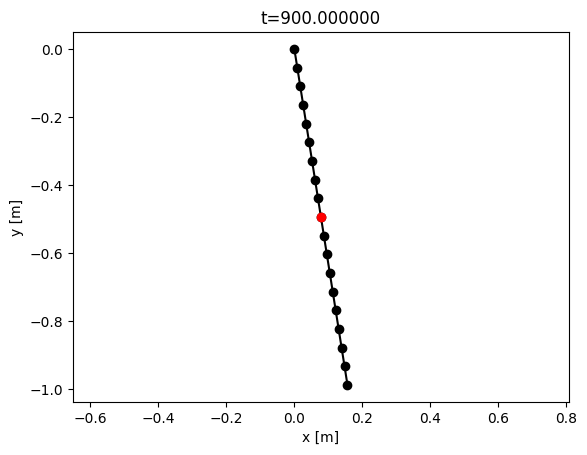

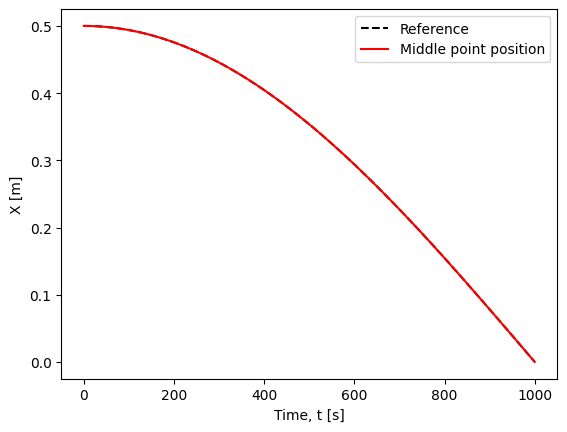

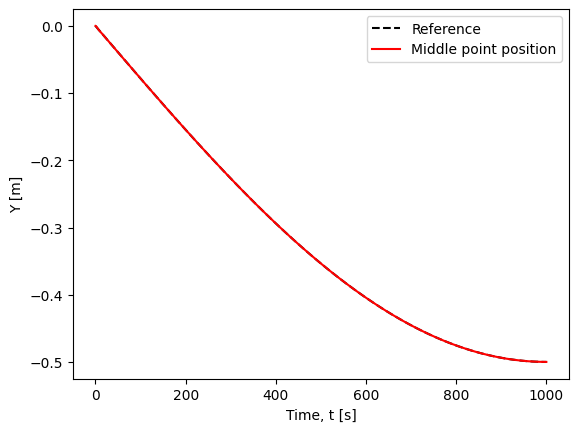

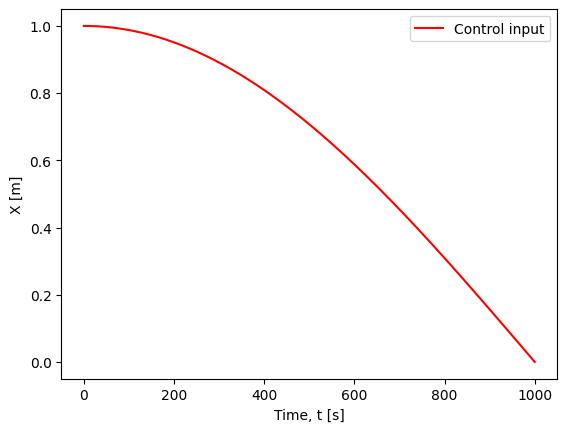

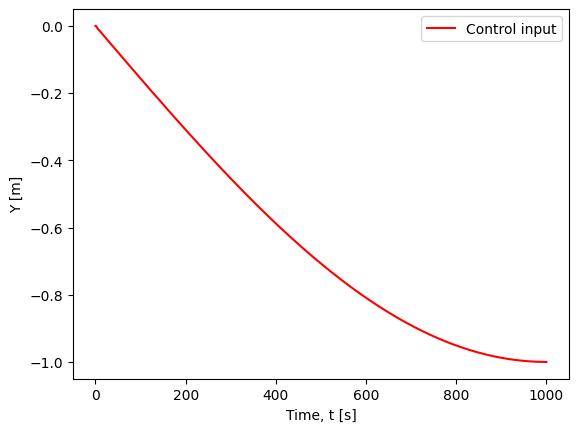

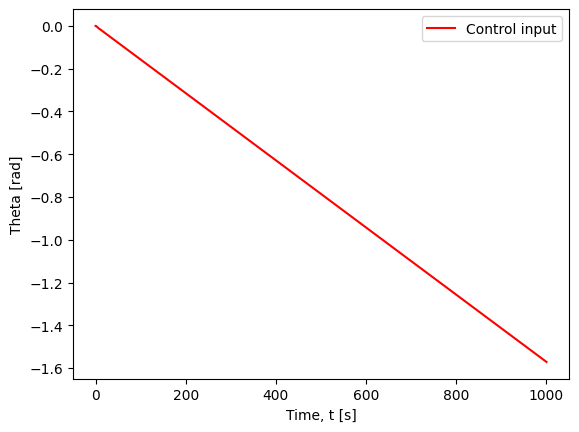

In [52]:
nodes, tol, m, mMat, EI, EA, W, C, deltaL, free_DOF = Initialization(nv, RodLength, d, R_inner, R_outer, Y, visc)
all_q = main(nodes, totalTime, dt, tol, maximum_iter, m, mMat, EI, EA, W, C, deltaL, free_DOF, midNode, RodLength, nv)

# t = np.arange(0,totalTime,dt)
# y_max = np.min(all_q, 1)
# plt.figure(5)
# plt.plot(t, y_max, 'r')
# plt.xlabel('Time, t [s]')
# plt.ylabel('Maximal Displacement, $\\delta$ [m]')
# plt.savefig('max_displace_vs_time.png')
# plt.show()